# Input driven ARHMM

In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.observations.ar_gaussian_observation import ARGaussianObservation
from ssm_ptc.transformations.linear import LinearTransformation
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from tqdm import tqdm_notebook as tqdm
import sys
import time

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

from ssm.hmm import HMM as ssm_HMM

In [3]:
npr.seed(0)
torch.manual_seed(0)

K = 3
D = 2
M = 1
T = 500


In [4]:
# Create an exogenous input
inpt = np.sin(2 * np.pi * np.arange(T) / 50)[:, None] + 1e-1 * npr.randn(T, M)
inpt = torch.tensor(inpt, dtype=torch.float64)

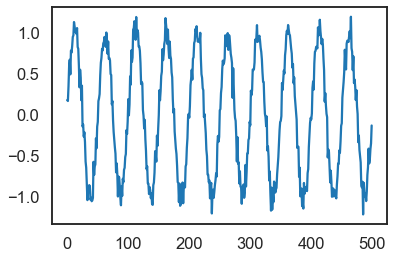

In [5]:
plt.plot(inpt.numpy())

# First, test ARGaussian observation

In [6]:
true_model = HMM(K=K, D=D, M=M, transition='inputdriven', observation='gaussian')

In [7]:
z, data = true_model.sample(T, input=inpt, return_np=True)

In [8]:
true_lls = true_model.log_likelihood(data, inpt)

Text(0, 0.5, 'observation')

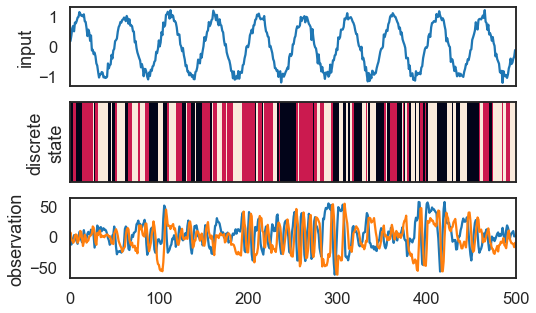

In [9]:
# Plot the data
plt.figure(figsize=(8, 5))

plt.subplot(311)
plt.plot(inpt.numpy())
plt.xticks([])
plt.xlim(0, T)
plt.ylabel("input")

plt.subplot(312)
plt.imshow(z[None, :], aspect="auto")
plt.xticks([])
plt.xlim(0, T)
plt.ylabel("discrete\nstate")
plt.yticks([])

plt.subplot(313)
plt.plot(data)
plt.xlim(0, T)
plt.ylabel("observation")

In [10]:
# Plot the observation distributions
lim = .85 * abs(data).max()
XX, YY = np.meshgrid(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100))
grid_values = np.column_stack((XX.ravel(), YY.ravel()))
grid_lls = true_model.observation.log_prob(torch.tensor(grid_values, dtype=torch.float64))

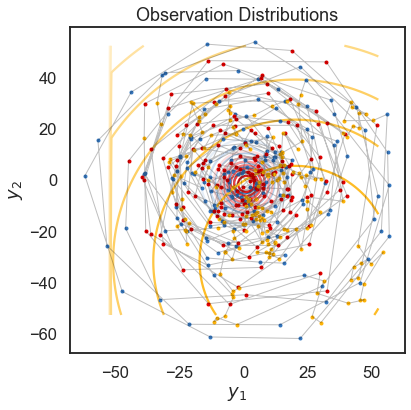

In [11]:
plt.figure(figsize=(6, 6))
for k in range(K):
    plt.contour(XX, YY, np.exp(grid_lls[:,k].detach().numpy()).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]))
    plt.plot(data[z==k, 0], data[z==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    
plt.plot(data[:,0], data[:,1], '-k', lw=1, alpha=.25)
plt.xlabel("$y_1$")
plt.ylabel("$y_2$")
plt.title("Observation Distributions");

In [12]:
XX_more, YY_more = np.meshgrid(np.linspace(-100, 100, 200), np.linspace(-100, 100, 200))

grid_values_more = np.column_stack((XX_more.ravel(), YY_more.ravel()))
grid_lls_more = true_model.observation.log_prob(torch.tensor(grid_values_more, dtype=torch.float64))

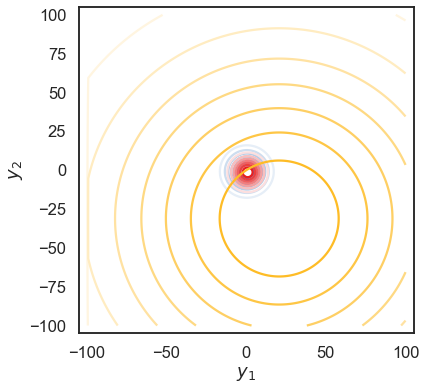

In [13]:
plt.figure(figsize=(6, 6))
for k in range(K):
    plt.contour(XX_more, YY_more, np.exp(grid_lls_more[:,k].detach().numpy()).reshape(XX_more.shape), cmap=white_to_color_cmap(colors[k]))

plt.xlabel("$y_1$")
plt.ylabel("$y_2$");

plt.xlim(-105, 105)
plt.ylim(-105, 105);

### Now, do learning

In [14]:
model = HMM(K=K, D=D, M=M, transition='inputdriven', observation='gaussian')

In [15]:
losses, optimizer = model.fit(data, input=inpt, num_iters=2000)

iter 1990 loss 3272.97: 100%|██████████| 2000/2000 [00:15<00:00, 123.78it/s]| 0/2000 [00:00<?, ?it/s]


In [16]:
losses_2, _ = model.fit(data, input=inpt, optimizer=optimizer, num_iters=2000)

iter 1990 loss 3233.75: 100%|██████████| 2000/2000 [00:16<00:00, 121.59it/s]| 0/2000 [00:00<?, ?it/s]


In [17]:
true_lls

tensor(-3247.5732, dtype=torch.float64, grad_fn=<HMMNormalizerCythonBackward>)

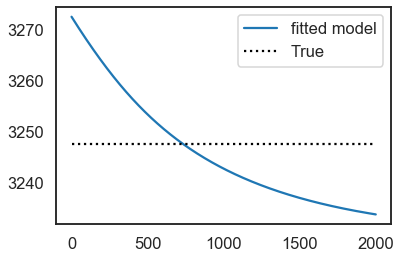

In [18]:
#true_loss = true_model.loss(data)
plt.plot(losses_2, label='fitted model')
plt.plot([0, 2000], -true_lls.detach().numpy() * np.ones(2), ':k', label="True")
plt.legend()
plt.show()

In [19]:
infer_z = model.most_likely_states(data, inpt)

perm = find_permutation(z, infer_z, K1=K, K2=K)

model.permute(perm)
infer_z = model.most_likely_states(data, inpt)

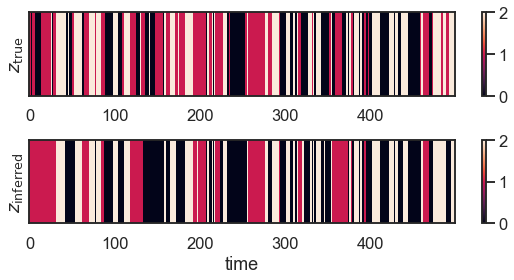

In [20]:
# Plot the true and inferred discrete states
slc = slice(0, T)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None, slc], aspect="auto")
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.colorbar()

plt.subplot(212)
plt.imshow(infer_z[None,slc], aspect="auto")
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")
plt.colorbar()

plt.tight_layout()

### Check prediction

In [21]:
x_predict_cond_z = k_step_prediction(model, z, data)

In [22]:
x_predict_cond_most_likely_z = k_step_prediction(model, infer_z, data)

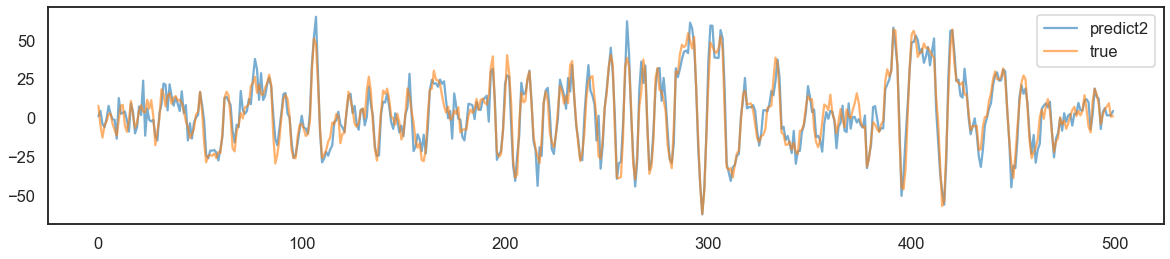

In [34]:
plt.figure(figsize=(20,4))

#plt.plot(x_predict_cond_z[:,0], label='predict')
plt.plot(x_predict_cond_most_likely_z[:,0], label='predict2', alpha=0.6)
plt.plot(data[:,0], label='true', alpha=0.6)
plt.legend()

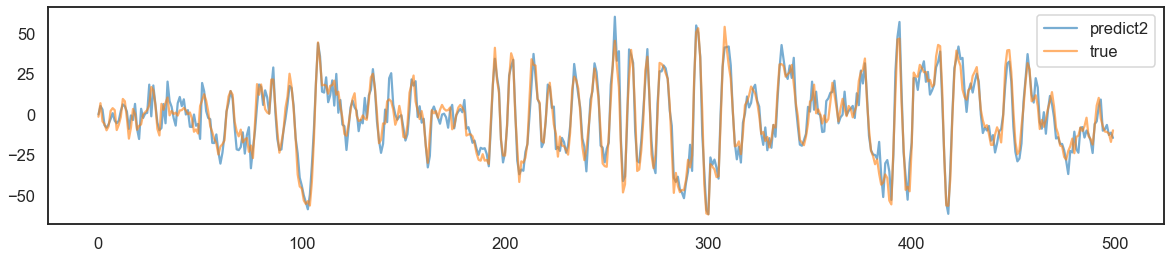

In [35]:
plt.figure(figsize=(20,4))
plt.plot(x_predict_cond_most_likely_z[:,1], label='predict2', alpha=0.6)
plt.plot(data[:,1], label='true', alpha=0.6)
plt.legend()

### check reconstruction

In [36]:
x_reconstruct = model.sample_condition_on_zs(z, torch.tensor(data[0], dtype=torch.float64))

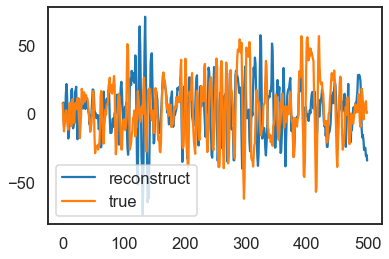

In [37]:
plt.plot(x_reconstruct[:,0], label='reconstruct')
plt.plot(data[:,0], label='true')
plt.legend()

# Test ARTruncatedNormal observation

In [39]:
torch.manual_seed(10)
npr.seed(10)

bounds = np.array([[-50,50], [-50, 50]])

In [40]:
true_model = HMM(K=K, D=D, M=M, transition='inputdriven', observation='truncatednormal', bounds=bounds)

In [41]:
z, data = true_model.sample(T, input=inpt, return_np=True)

In [42]:
true_lls = true_model.log_likelihood(data, inpt)

In [43]:
true_lls

tensor(-1653.0227, dtype=torch.float64, grad_fn=<HMMNormalizerCythonBackward>)

Text(0, 0.5, 'observation')

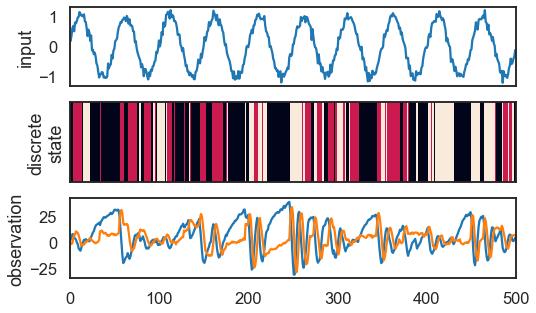

In [44]:
# Plot the data
plt.figure(figsize=(8, 5))

plt.subplot(311)
plt.plot(inpt.numpy())
plt.xticks([])
plt.xlim(0, T)
plt.ylabel("input")

plt.subplot(312)
plt.imshow(z[None, :], aspect="auto")
plt.xticks([])
plt.xlim(0, T)
plt.ylabel("discrete\nstate")
plt.yticks([])

plt.subplot(313)
plt.plot(data)
plt.xlim(0, T)
plt.ylabel("observation")

In [45]:
# Plot the observation distributions
lim = .85 * abs(data).max()
XX, YY = np.meshgrid(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100))
grid_values = np.column_stack((XX.ravel(), YY.ravel()))
grid_lls = true_model.observation.log_prob(torch.tensor(grid_values, dtype=torch.float64))

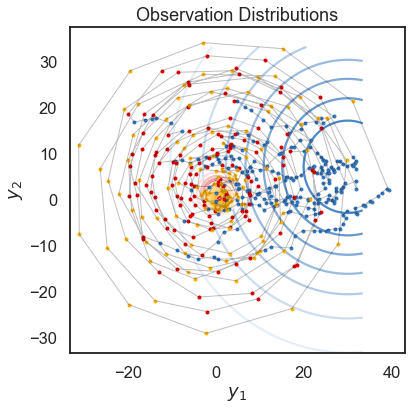

In [46]:
plt.figure(figsize=(6, 6))
for k in range(K):
    plt.contour(XX, YY, np.exp(grid_lls[:,k].detach().numpy()).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]))
    plt.plot(data[z==k, 0], data[z==k, 1], 'o', mfc=colors[k], mec='none', ms=4)
    
plt.plot(data[:,0], data[:,1], '-k', lw=1, alpha=.25)
plt.xlabel("$y_1$")
plt.ylabel("$y_2$")
plt.title("Observation Distributions");

In [49]:
XX_more, YY_more = np.meshgrid(np.linspace(-50, 50, 200), np.linspace(-50, 50, 200))

grid_values_more = np.column_stack((XX_more.ravel(), YY_more.ravel()))
grid_lls_more = true_model.observation.log_prob(torch.tensor(grid_values_more, dtype=torch.float64))

#### note: the grid value lls is kinda weird thing to do.. since it is AR observation.

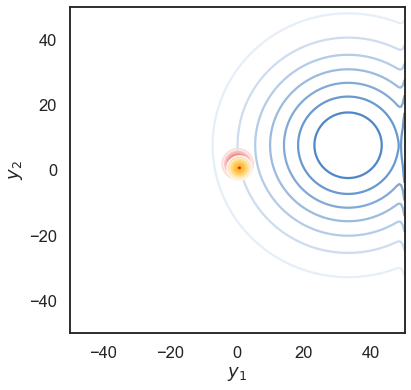

In [50]:
plt.figure(figsize=(6, 6))
for k in range(K):
    plt.contour(XX_more, YY_more, np.exp(grid_lls_more[:,k].detach().numpy()).reshape(XX_more.shape), cmap=white_to_color_cmap(colors[k]))

plt.xlabel("$y_1$")
plt.ylabel("$y_2$");

plt.xlim(-50, 50)
plt.ylim(-50, 50);

### now, do learning

In [51]:
model = HMM(K=K, D=D, M=M, transition='inputdriven', observation='gaussian')

In [52]:
losses, optimizer = model.fit(data, input=inpt, num_iters=4000, lr=0.001)

iter 3990 loss 1639.09: 100%|██████████| 4000/4000 [00:32<00:00, 122.91it/s]| 0/4000 [00:00<?, ?it/s]


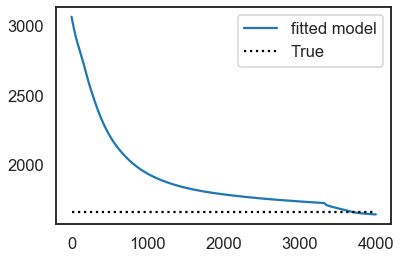

In [57]:
#true_loss = true_model.loss(data)
plt.plot(losses, label='fitted model')
plt.plot([0, 4000], -true_lls.detach().numpy() * np.ones(2), ':k', label="True")
plt.legend()
plt.show()

In [58]:
infer_z = model.most_likely_states(data, inpt)

perm = find_permutation(z, infer_z, K1=K, K2=K)

model.permute(perm)
infer_z = model.most_likely_states(data, inpt)

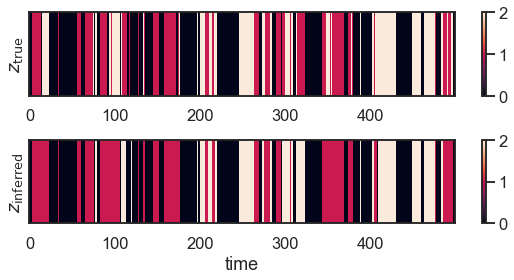

In [59]:
# Plot the true and inferred discrete states
slc = slice(0, T)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None, slc], aspect="auto")
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.colorbar()

plt.subplot(212)
plt.imshow(infer_z[None,slc], aspect="auto")
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")
plt.colorbar()

plt.tight_layout()

### check prediction

In [60]:
x_predict_cond_z = k_step_prediction(model, z, data)

In [61]:
x_predict_cond_most_likely_z = k_step_prediction(model, infer_z, data)

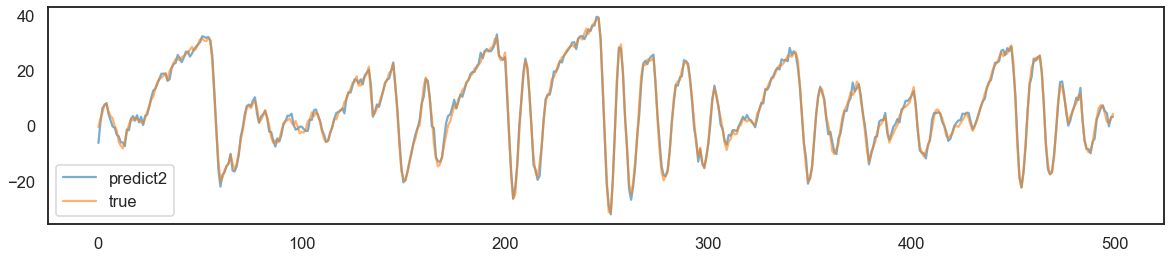

In [62]:
plt.figure(figsize=(20,4))

#plt.plot(x_predict_cond_z[:,0], label='predict')
plt.plot(x_predict_cond_most_likely_z[:,0], label='predict2', alpha=0.6)
plt.plot(data[:,0], label='true', alpha=0.6)
plt.legend()

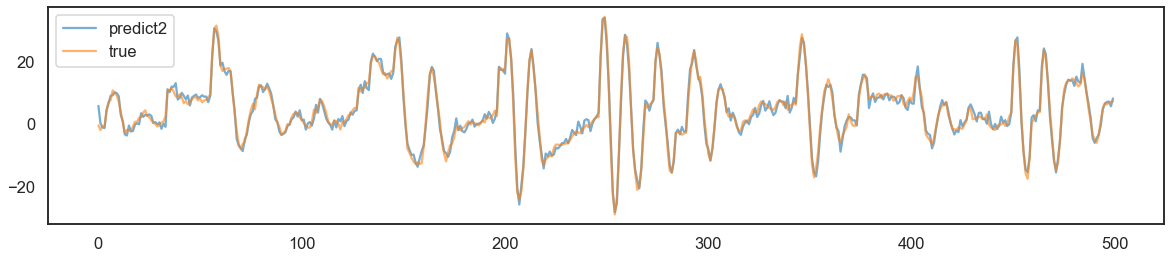

In [63]:
plt.figure(figsize=(20,4))

#plt.plot(x_predict_cond_z[:,0], label='predict')
plt.plot(x_predict_cond_most_likely_z[:,1], label='predict2', alpha=0.6)
plt.plot(data[:,1], label='true', alpha=0.6)
plt.legend()

### check reconstruction

In [64]:
x_reconstruct = model.sample_condition_on_zs(z, torch.tensor(data[0], dtype=torch.float64))

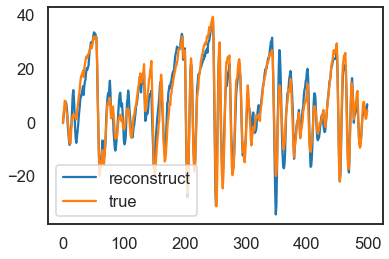

In [65]:
plt.plot(x_reconstruct[:,0], label='reconstruct')
plt.plot(data[:,0], label='true')
plt.legend()

Closing thought: it seems like that TN observation fits better than Gaussian observation.